# Predicting demand of Uber Service
## Project 2: Exploration
## Jose Oros, Annamali Kathir

On demand ride services have been experimenting a high growth in the past 5 years, with increasing number of competitors and demand of the service, changing the transportation in the city. We are interested in analyzing the demand of the service and its relation to passenger demographics, so we can understand how the service is proliferating in the market. 


In [2]:
#import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, r2_score, mean_absolute_error, mean_squared_error


%matplotlib inline

First we read the data

In [3]:
demo_df = pd.read_csv('../Data/demographics.csv')
zones_df = pd.read_csv('../Data/zones.csv')
geo_df = pd.read_csv('../Data/geographic.csv')
bases_df = pd.read_csv('../Data/bases.csv')

In [4]:
trip_15 = pd.read_csv('../Data/uber_trips_2015.csv')
trip_14= pd.read_csv('../Data/uber_trips_2014.csv')

We found that we do not have the data of the NTA code directly in the 2014 trips, but we have the coordinates of the trip. We need to map our coordinates to a NTA code.

In [5]:
#Extra code to single columns:

In [9]:
#Map geo_data latitudes and long to columns
geo_df_2 = pd.DataFrame()
long = []
lat = []
nta = []
for col in geo_df:
    count = 0
    for coord in geo_df[col].dropna():
        if count % 2 == 0:
            long.append(coord)
            nta.append(col)
        else:
            lat.append(coord)
        count += 1    
geo_df_2['nta'] = nta
geo_df_2['lat'] = lat
geo_df_2['long'] = long
    
#to csv
geo_df_2.to_csv('nta_zones.csv')

Now, we have to check to what NTA code the coordinates belong, so we will first create a dictionary of NTA codes and then all the coordinates of the 2014 trips to assign the right NTA code 

In [6]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [7]:
#creating a polygon for each of the NTA CODES in a dictionary, having the NTA code as the key and the polygon as the value
geo_new = {}
for col in geo_df:
    count = 0
    long = []
    lat = []
    for coord in geo_df[col].dropna():
        if count % 2 == 0:
            long.append(coord)
        else:
            lat.append(coord)
        count += 1
    
    poly = Polygon(list(zip(lat,long)))
    geo_new[col] = poly
    

In [8]:
#Function to check coordinates and output what NTA code they belong to
def check_coords(point, geo_new):
    for key,area in geo_new.items():
        if area.contains(Point(point)):
            return key
    

In [9]:
#run the function
trip_14_sub = trip_14.sample(50000)
trip_14_sub['zipped'] = list(zip(trip_14_sub['pickup_latitude'],trip_14_sub['pickup_longitude']))
trip_14_sub['nta_code'] = [check_coords(x,geo_new) for x in trip_14_sub['zipped']]

In [10]:
#drop null values
trip_14_sub.dropna(inplace=True)

In [12]:
#show data with new NTA CODE column
trip_14_sub.head()

,pickup_datetime,pickup_latitude,pickup_longitude,base,zipped,nta_code
1414991,6/20/2014 17:19:00,40.7295,-73.9998,B02598,"(40.7295, -73.9998)",MN23
3454104,8/31/2014 9:03:00,40.6896,-73.9670,B02682,"(40.6896, -73.967)",BK69
747193,5/17/2014 19:03:00,40.7608,-73.9962,B02598,"(40.7608, -73.9962)",MN15
1868789,6/30/2014 12:47:00,40.7542,-73.9961,B02682,"(40.7542, -73.9961)",MN13
1797410,6/18/2014 22:14:00,40.7164,-73.9959,B02682,"(40.7164, -73.9959)",MN27


Now, we need to find the NTA code for the data of 2015, so we are going to join the dataframes of trips 2015 and the zones that coontains the id and the nta code (join them by nta code id)

In [13]:
trip_15_all = pd.merge(trip_15, zones_df, how='inner', left_on='pickup_location_id', right_on='location_id')


We are interested in selecting only pick up date and NTA code for both 2014 and 2015

In [14]:
trip_15_all.head()

,pickup_datetime,pickup_location_id,dispatch_base,affiliate_base,location_id,borough,zone,service_zone,nta_code
0,2015-05-17 09:47:00,141,B02617,B02617,141,Manhattan,Lenox Hill West,Yellow Zone,MN31
1,2015-05-17 09:50:00,141,B02617,B02617,141,Manhattan,Lenox Hill West,Yellow Zone,MN31
2,2015-05-17 09:53:00,141,B02617,B02617,141,Manhattan,Lenox Hill West,Yellow Zone,MN31
3,2015-05-17 10:00:00,141,B02617,B02617,141,Manhattan,Lenox Hill West,Yellow Zone,MN31
4,2015-05-17 10:00:00,141,B02617,B02617,141,Manhattan,Lenox Hill West,Yellow Zone,MN31


In [15]:
trip_14_sub.head()

,pickup_datetime,pickup_latitude,pickup_longitude,base,zipped,nta_code
1414991,6/20/2014 17:19:00,40.7295,-73.9998,B02598,"(40.7295, -73.9998)",MN23
3454104,8/31/2014 9:03:00,40.6896,-73.9670,B02682,"(40.6896, -73.967)",BK69
747193,5/17/2014 19:03:00,40.7608,-73.9962,B02598,"(40.7608, -73.9962)",MN15
1868789,6/30/2014 12:47:00,40.7542,-73.9961,B02682,"(40.7542, -73.9961)",MN13
1797410,6/18/2014 22:14:00,40.7164,-73.9959,B02682,"(40.7164, -73.9959)",MN27


In [16]:
#select columns of interest for 2014 and 2015
trip_15_all = trip_15_all[['pickup_datetime', 'nta_code']]

In [17]:
trip_14_sub = trip_14_sub[['pickup_datetime', 'nta_code']]

In [18]:
#convert pick up date and time to datetime type
trip_15_all['pickup_datetime'] = pd.to_datetime(trip_15_all['pickup_datetime'])
trip_14_sub['pickup_datetime'] = pd.to_datetime(trip_14_sub['pickup_datetime'])

In [19]:
#include time variables to the 

#2015 data
trip_15_all['time'] = trip_15_all.pickup_datetime.dt.time
trip_15_all['hour'] = trip_15_all.pickup_datetime.dt.hour
trip_15_all['day_week'] = trip_15_all.pickup_datetime.dt.dayofweek
trip_15_all['day_month'] = trip_15_all.pickup_datetime.dt.day
trip_15_all['day_year'] = trip_15_all.pickup_datetime.dt.dayofyear
trip_15_all['month'] = trip_15_all.pickup_datetime.dt.month
trip_15_all['date_only'] = trip_15_all.pickup_datetime.dt.date
trip_15_all['trip'] = 1

#2014 data
trip_14_sub['time'] = trip_14_sub.pickup_datetime.dt.time
trip_14_sub['hour'] = trip_14_sub.pickup_datetime.dt.hour
trip_14_sub['day_week'] = trip_14_sub.pickup_datetime.dt.dayofweek
trip_14_sub['day_month'] = trip_14_sub.pickup_datetime.dt.day
trip_14_sub['day_year'] = trip_14_sub.pickup_datetime.dt.dayofyear
trip_14_sub['month'] = trip_14_sub.pickup_datetime.dt.month
trip_14_sub['date_only'] = trip_14_sub.pickup_datetime.dt.date
trip_14_sub['trip'] = 1



In [20]:
trip_15_all.head()

,pickup_datetime,nta_code,time,hour,day_week,day_month,day_year,month,date_only,trip
0,2015-05-17 09:47:00,MN31,09:47:00,9,6,17,137,5,2015-05-17,1
1,2015-05-17 09:50:00,MN31,09:50:00,9,6,17,137,5,2015-05-17,1
2,2015-05-17 09:53:00,MN31,09:53:00,9,6,17,137,5,2015-05-17,1
3,2015-05-17 10:00:00,MN31,10:00:00,10,6,17,137,5,2015-05-17,1
4,2015-05-17 10:00:00,MN31,10:00:00,10,6,17,137,5,2015-05-17,1


# Exploratory analysis of the demand

### 2015 demand all year

In [21]:
trip_15_all.columns

Index(['pickup_datetime', 'nta_code', 'time', 'hour', 'day_week', 'day_month',
       'day_year', 'month', 'date_only', 'trip'],
      dtype='object')

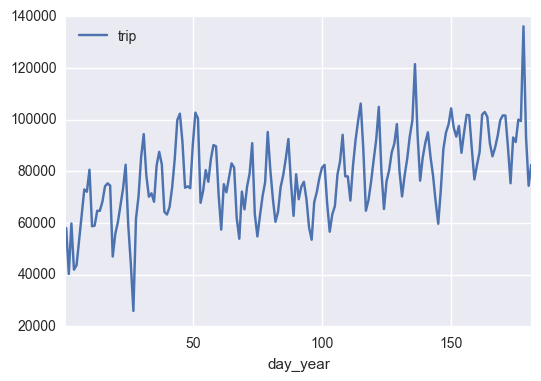

In [22]:
trip_15_all.groupby(['day_year']).agg({'trip': np.sum}).plot(kind='line')

### 2015 demand by month

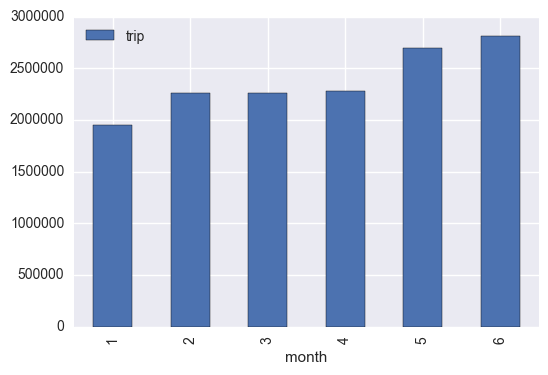

In [23]:
trip_15_all.groupby(['month']).agg({'trip': np.sum}).plot(kind='bar')

### 2015 Demand by time of day

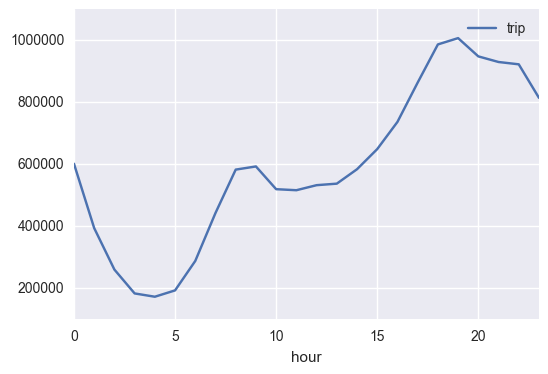

In [24]:
trip_15_all.groupby(['hour']).agg({'trip': np.sum}).plot(kind='line')

### 2015 demand by day of the week

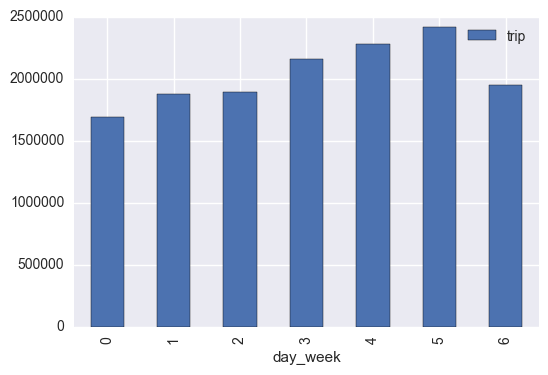

In [25]:
trip_15_all.groupby(['day_week']).agg({'trip': np.sum}).plot(kind='bar')

Let us look closer at the day of the week 5 (Saturday)

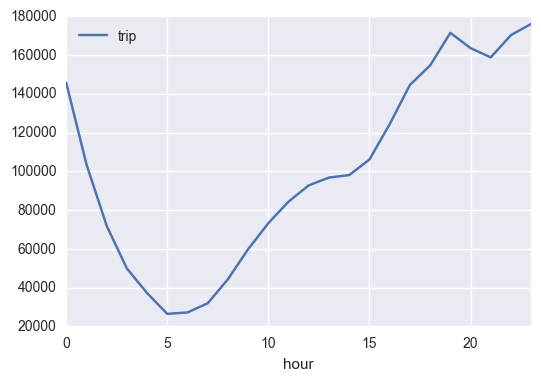

In [26]:
trip_15_all[trip_15_all['day_week'] == 5].groupby(['hour']).agg({'trip': np.sum}).plot(kind='line')

### 2015 demand by day of month

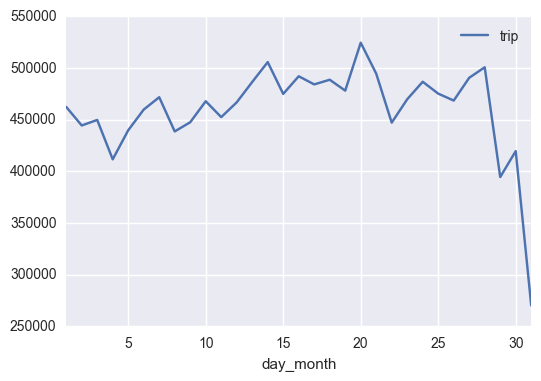

In [27]:
trip_15_all.groupby(['day_month']).agg({'trip': np.sum}).plot(kind='line')

In [28]:
#trip_15_all['time_range'] = np.where(trip_15_all['time'] <= 12, 'test')
#trip_14_sub['time_range'] = trip_14_sub.pickup_datetime.dt.dayofweek

In [29]:
#output csv for both years
trip_15_all.to_csv('trip_15_all.csv')
trip_14_sub.to_csv('trip_14_sub.csv')

## Distribution of Trips

C:\Users\jose oros\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


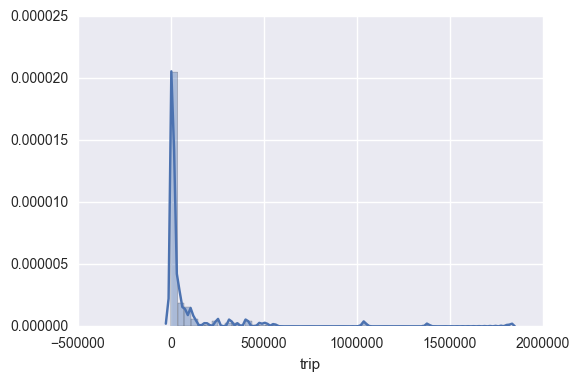

In [30]:
distribution = trip_15_all.groupby(['nta_code']).agg({'trip': np.sum})
distribution = distribution.reset_index()
#distribution['trip'] = np.log(distribution['trip'])
sns.distplot(distribution['trip'])


Let us look to the top 10 zones

In [31]:
#number of NTA zones
len(distribution)

190

In [32]:
distribution['perc'] = round(distribution['trip']/distribution.trip.sum(),4)

In [33]:
distribution.sort_values('trip', ascending=False).head(10)

,nta_code,trip,perc
95,MN17,1822472,0.1278
92,MN13,1380265,0.0968
100,MN23,1044279,0.0732
101,MN24,1033898,0.0725
171,QN98,555288,0.0389
111,MN40,513858,0.0360
99,MN22,496910,0.0348
102,MN25,473634,0.0332
97,MN20,414087,0.0290
94,MN15,406319,0.0285


There are four NTA codes that belong to the largest proportion of trips in 2015. They are the following:

In [34]:
zones_df[(zones_df.nta_code == 'MN174') | (zones_df.nta_code == 'MN13')|(zones_df.nta_code == 'MN23')|(zones_df.nta_code == 'MN24')]

,location_id,borough,zone,service_zone,nta_code
67,68,Manhattan,East Chelsea,Yellow Zone,MN13
89,90,Manhattan,Flatiron,Yellow Zone,MN13
99,100,Manhattan,Garment District,Yellow Zone,MN13
112,113,Manhattan,Greenwich Village North,Yellow Zone,MN23
113,114,Manhattan,Greenwich Village South,Yellow Zone,MN23
124,125,Manhattan,Hudson Sq,Yellow Zone,MN24
143,144,Manhattan,Little Italy/NoLiTa,Yellow Zone,MN24
157,158,Manhattan,Meatpacking/West Village West,Yellow Zone,MN23
210,211,Manhattan,SoHo,Yellow Zone,MN24
230,231,Manhattan,TriBeCa/Civic Center,Yellow Zone,MN24


In [35]:
trip_15_all.shape

(14264215, 10)

# Demographic information

We are interested in seeing how the demographics of a NTA code affect the number of trips in the area. We will join the demographics table with the total number of trips in 2015 table and run a regression on the number of trips to see what features affect the most.

Let us take a look to the demographic data frame

In [36]:
# number of nta_codes in demographic data set
len(demo_df)

188

In [37]:
#columns
demo_df.columns

Index(['nta_name', 'borough', 'nta_code', 'population', 'under_5_years',
       '5-9_years', '10-14_years', '15-19_years', '20-24_years', '25-29_years',
       '30-34_years', '35-39_years', '40-44_years', '45-49_years',
       '50-54_years', '55-59_years', '60-64_years', 'over_65_years',
       'median_age', 'people_per_acre', 'households', 'less_than_10,000',
       '10000_to_14999', '15000_to_24999', '25000_to_34999', '35000_to_49999',
       '50000_to_74999', '75000_to_99999', '100000_to_149999',
       '150000_to_199999', '200000_or_more', 'median_income', 'mean_income'],
      dtype='object')

In [38]:
demo_df.head()

,nta_name,borough,nta_code,population,under_5_years,5-9_years,10-14_years,15-19_years,20-24_years,25-29_years,...,15000_to_24999,25000_to_34999,35000_to_49999,50000_to_74999,75000_to_99999,100000_to_149999,150000_to_199999,200000_or_more,median_income,mean_income
0,Allerton-Pelham Gardens,Bronx,BX31,28903,1679,1706,1763,2039,1964,1703,...,797,773,1160,1764,1155,1562,765,427,61638,78489
1,Annadale-Huguenot-Prince's Bay-Eltingville,Staten Island,SI01,27770,1397,1698,1817,1880,1720,1594,...,571,405,1008,1523,1346,2075,1086,1151,88288,109187
2,Arden Heights,Staten Island,SI48,25238,1507,1540,1596,1752,1614,1561,...,337,516,707,1421,1611,2021,1047,740,89570,101627
3,Astoria,Queens,QN70,78793,3480,3037,3060,3392,6630,11586,...,3673,2816,4725,6463,4557,4698,1627,1197,54882,70094
4,Auburndale,Queens,QN48,19996,917,966,1063,1168,1214,1307,...,445,632,690,1417,1060,1237,589,433,70772,84402


Now, we want the total number of trips data frame (distribution) and the demographic data frame (demo_df) to be able to run the regression.

In [39]:
demo_trips = pd.merge(demo_df, distribution, how='inner', on='nta_code',)

In [40]:
demo_trips.head()

,nta_name,borough,nta_code,population,under_5_years,5-9_years,10-14_years,15-19_years,20-24_years,25-29_years,...,35000_to_49999,50000_to_74999,75000_to_99999,100000_to_149999,150000_to_199999,200000_or_more,median_income,mean_income,trip,perc
0,Allerton-Pelham Gardens,Bronx,BX31,28903,1679,1706,1763,2039,1964,1703,...,1160,1764,1155,1562,765,427,61638,78489,3684,0.0003
1,Annadale-Huguenot-Prince's Bay-Eltingville,Staten Island,SI01,27770,1397,1698,1817,1880,1720,1594,...,1008,1523,1346,2075,1086,1151,88288,109187,39,0.0000
2,Arden Heights,Staten Island,SI48,25238,1507,1540,1596,1752,1614,1561,...,707,1421,1611,2021,1047,740,89570,101627,26,0.0000
3,Astoria,Queens,QN70,78793,3480,3037,3060,3392,6630,11586,...,4725,6463,4557,4698,1627,1197,54882,70094,91239,0.0064
4,Auburndale,Queens,QN48,19996,917,966,1063,1168,1214,1307,...,690,1417,1060,1237,589,433,70772,84402,3040,0.0002


In [41]:
demo_trips.shape

(185, 35)

In [43]:
demo_trips.columns

Index(['nta_name', 'borough', 'nta_code', 'population', 'under_5_years',
       '5-9_years', '10-14_years', '15-19_years', '20-24_years', '25-29_years',
       '30-34_years', '35-39_years', '40-44_years', '45-49_years',
       '50-54_years', '55-59_years', '60-64_years', 'over_65_years',
       'median_age', 'people_per_acre', 'households', 'less_than_10,000',
       '10000_to_14999', '15000_to_24999', '25000_to_34999', '35000_to_49999',
       '50000_to_74999', '75000_to_99999', '100000_to_149999',
       '150000_to_199999', '200000_or_more', 'median_income', 'mean_income',
       'trip', 'perc'],
      dtype='object')

In [50]:
demo_trips.drop(['nta_name', 'borough', 'nta_code'],axis=1).corr(method = 'pearson')

,population,under_5_years,5-9_years,10-14_years,15-19_years,20-24_years,25-29_years,30-34_years,35-39_years,40-44_years,...,25000_to_34999,35000_to_49999,50000_to_74999,75000_to_99999,100000_to_149999,150000_to_199999,200000_or_more,median_income,trip,perc
population,1.000000,0.840328,0.811815,0.788264,0.790010,0.873658,0.851319,0.886797,0.946139,0.966472,...,0.909648,0.935141,0.928010,0.800820,0.635509,0.480562,0.376954,-0.089327,0.168846,0.168940
under_5_years,0.840328,1.000000,0.972232,0.920468,0.857446,0.745326,0.613243,0.657415,0.724919,0.738924,...,0.805616,0.768365,0.666355,0.468958,0.284902,0.158437,0.103394,-0.318835,-0.040610,-0.040520
5-9_years,0.811815,0.972232,1.000000,0.981890,0.924145,0.722846,0.515948,0.556812,0.655001,0.714899,...,0.809012,0.760764,0.628010,0.399312,0.180857,0.031194,-0.035993,-0.412213,-0.139213,-0.139135
10-14_years,0.788264,0.920468,0.981890,1.000000,0.954737,0.709472,0.458939,0.494438,0.608075,0.700522,...,0.809472,0.759268,0.611693,0.372059,0.128280,-0.037295,-0.114229,-0.459964,-0.189236,-0.189139
15-19_years,0.790010,0.857446,0.924145,0.954737,1.000000,0.802394,0.507559,0.515886,0.613213,0.702971,...,0.823600,0.758706,0.614868,0.376164,0.116208,-0.030122,-0.110633,-0.473084,-0.109086,-0.108998
20-24_years,0.873658,0.745326,0.722846,0.709472,0.802394,1.000000,0.859896,0.805618,0.808586,0.803779,...,0.835178,0.815063,0.766548,0.619396,0.434844,0.300645,0.232004,-0.192636,0.221757,0.221775
25-29_years,0.851319,0.613243,0.515948,0.458939,0.507559,0.859896,1.000000,0.972681,0.915851,0.835843,...,0.733975,0.786743,0.843518,0.805140,0.722968,0.621861,0.556996,0.100109,0.415531,0.415533
30-34_years,0.886797,0.657415,0.556812,0.494438,0.515886,0.805618,0.972681,1.000000,0.971606,0.898508,...,0.759816,0.825212,0.886192,0.849217,0.759792,0.655108,0.569759,0.118212,0.377643,0.377693
35-39_years,0.946139,0.724919,0.655001,0.608075,0.613213,0.808586,0.915851,0.971606,1.000000,0.968604,...,0.825228,0.886801,0.926346,0.858400,0.735142,0.607593,0.501522,0.059900,0.286805,0.286896
40-44_years,0.966472,0.738924,0.714899,0.700522,0.702971,0.803779,0.835843,0.898508,0.968604,1.000000,...,0.867712,0.917452,0.929764,0.827234,0.670414,0.522276,0.416186,-0.022604,0.196597,0.196720


In [51]:
demo_df.head()

,nta_name,borough,nta_code,population,under_5_years,5-9_years,10-14_years,15-19_years,20-24_years,25-29_years,...,15000_to_24999,25000_to_34999,35000_to_49999,50000_to_74999,75000_to_99999,100000_to_149999,150000_to_199999,200000_or_more,median_income,mean_income
0,Allerton-Pelham Gardens,Bronx,BX31,28903,1679,1706,1763,2039,1964,1703,...,797,773,1160,1764,1155,1562,765,427,61638,78489
1,Annadale-Huguenot-Prince's Bay-Eltingville,Staten Island,SI01,27770,1397,1698,1817,1880,1720,1594,...,571,405,1008,1523,1346,2075,1086,1151,88288,109187
2,Arden Heights,Staten Island,SI48,25238,1507,1540,1596,1752,1614,1561,...,337,516,707,1421,1611,2021,1047,740,89570,101627
3,Astoria,Queens,QN70,78793,3480,3037,3060,3392,6630,11586,...,3673,2816,4725,6463,4557,4698,1627,1197,54882,70094
4,Auburndale,Queens,QN48,19996,917,966,1063,1168,1214,1307,...,445,632,690,1417,1060,1237,589,433,70772,84402


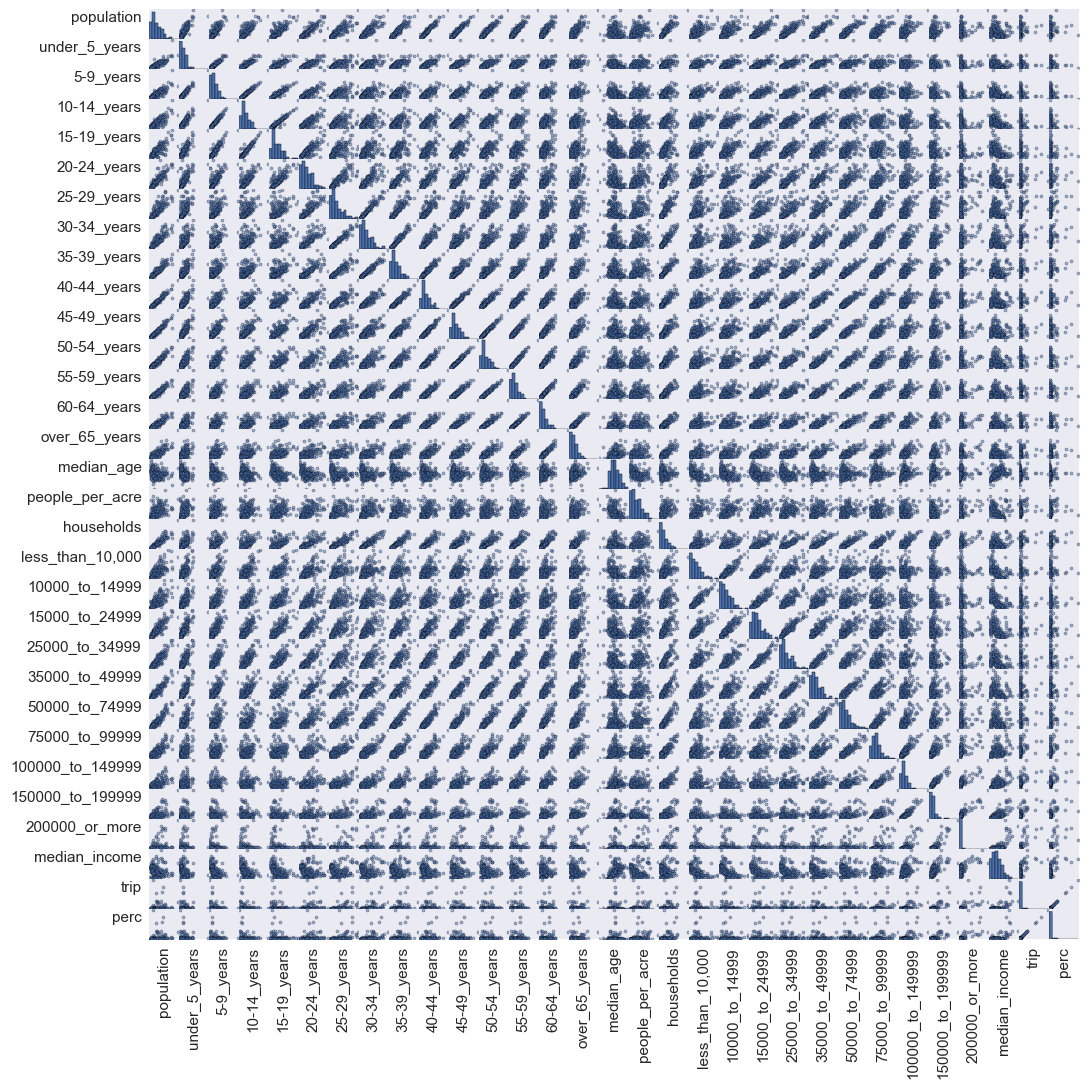

In [52]:
df_num = demo_trips.drop(['nta_name', 'borough', 'nta_code'],axis=1)
axs = pd.scatter_matrix(df_num, figsize=(12, 12));

# Rotate axis labels and remove axis ticks
n = len(df_num.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [49]:
demo_trips = demo_trips.drop(['mean_income'], axis=1)

In [385]:
#output csv for demo_trips
demo_trips.to_csv('demo_trips.csv')

## Regression Models

We are going to run a regression model over the total number of trips.

In [53]:
#create dummy variables
nta_dummies = pd.get_dummies(demo_trips['nta_code'])

In [54]:
#concatenate
demo_trips_2 = pd.concat([demo_trips,nta_dummies], axis=1)
#demo_trips_2['trip'] = np.log(demo_trips_2['trip'])

In [55]:
demo_trips_2.shape

(185, 219)

In [56]:
demo_trips_2.columns

Index(['nta_name', 'borough', 'nta_code', 'population', 'under_5_years',
       '5-9_years', '10-14_years', '15-19_years', '20-24_years', '25-29_years',
       ...
       'SI24', 'SI25', 'SI28', 'SI32', 'SI35', 'SI36', 'SI37', 'SI45', 'SI48',
       'SI54'],
      dtype='object', length=219)

In [57]:
#drop columns that are repetitve
demo_trips_2 = demo_trips_2.drop(['nta_name','nta_code', 'borough', 'perc'], axis=1)


In [62]:
x = demo_trips_2.drop('trip', axis=1)
y = demo_trips_2.trip
x.shape, y.shape

((185, 214), (185,))

In [231]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20)

### Linear Regression

In [232]:
regr = LinearRegression()
regr.fit(x_train, y_train)
predicted = regr.predict(x_test)

In [233]:
# The coefficients
#print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error:")
print(np.mean((predicted - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('R2:')
print(regr.score(x_test, y_test))

Mean squared error:
20176125675.49562
R2:
0.454421607422


### Random Forest Regression

In [234]:
rf_regr = RandomForestRegressor()
rf_regr.fit(x_train, y_train)
predicted = rf_regr.predict(x_test)

In [235]:
# The coefficients
#print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error:")
print(np.mean((predicted - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('R2:')
print(rf_regr.score(x_test, y_test))

Mean squared error:
47388177677.48324
R2:
-0.281413796697


Let us look at the most important features

In [236]:
features = x_train.columns
importances = rf_regr.feature_importances_
feat_df = pd.DataFrame()
feat_df['Features'] = features
feat_df['Importance'] = importances
feat_df.sort_values(by='Importance', ascending=False).head(10)

,Features,Importance
28,median_income,0.450026
27,200000_or_more,0.241729
19,10000_to_14999,0.087649
123,MN17,0.063354
7,30-34_years,0.041573
9,40-44_years,0.024187
0,population,0.011422
22,35000_to_49999,0.010344
18,"less_than_10,000",0.008386
10,45-49_years,0.007675


By looking at the feature importance through several iterations, we can see that mean_income and median income are recurring features for the regressor, as well as being in a dense area or not.